# PMAP Comorbidity Info Feature Engineering
Created: January 6, 2023\
*Last Modified: January 23, 2023*

This notebook generates binary flags of Elixhauser comorbidity information of CHF hospital stays w/ ICU.\
Reference for the ICD-10 coding algorithm for Elixhauser comorbidities are from the [Agency for Healthcare Research and Quality (AHRQ)](https://hcup-us.ahrq.gov/toolssoftware/comorbidityicd10/comorbidity_icd10.jsp).

Author: Vina Ro

In [1]:
# Import packages
import numpy as np
import pandas as pd
import time as time
import seaborn as sns
import missingno as msno
from matplotlib import pyplot as plt
from pathlib import Path
from datetime import datetime

In [2]:
# Set filepath
file_path = Path('PMAP_Comorbidity.ipynb').resolve()
data_path = file_path.parent.parent.parent.parent.parent.joinpath('Data/jbergma8/IRB_271579_Faraday/IRB-271579-v3-DEID-220607-no-ptsd')

In [3]:
# Import data
# PMAP diagnosis data is included in encounter_dx.csv, hosp_billing_dx.csv, and problem_list.csv
ahrq_elix          = pd.read_excel('AHRQ_Elixhauser.xlsx', sheet_name='DX_to_Comorb_Mapping', header = 1)
enc_dx             = pd.read_csv(data_path / 'encounter_dx.csv', parse_dates = ['enc_contact_date'], usecols = ['osler_sid','pat_enc_csn_sid', 'icd10_code', 'enc_contact_date'])
CHF_hosp_icu_stays = pd.read_csv('CHF_hosp_icu_stays.csv', parse_dates = ['hosp_admsn_time','hosp_disch_time','in_time','out_time'])
hosp_billing       = pd.read_csv(data_path / 'hosp_billing_dx.csv', usecols = ['osler_sid', 'pat_enc_csn_sid','icd10_code'])
prob_list          = pd.read_csv(data_path / 'problem_list.csv', parse_dates = ['noted_date'], usecols = ['osler_sid','problem_list_id', 'icd10_code', 'noted_date'])       

## Data Cleaning
### 1. Elixhauser References from AHRQ 

In [4]:
ahrq_elix.head()

,ICD-10-CM Diagnosis,ICD-10-CM Code Description,# Comorbidities,AIDS,ALCOHOL,ANEMDEF,AUTOIMMUNE,BLDLOSS,CANCER_LEUK,CANCER_LYMPH,...,PERIVASC,PSYCHOSES,PULMCIRC,RENLFL_MOD,RENLFL_SEV,THYROID_HYPO,THYROID_OTH,ULCER_PEPTIC,VALVE,WGHTLOSS
0,A1801,Tuberculosis of spine,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A1802,Tuberculous arthritis of other joints,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A1884,Tuberculosis of heart,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,A3282,Listerial endocarditis,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,A3951,Meningococcal endocarditis,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
# change icd10 codes in the ahrq_elix dataframe to the standard formatting (a period following three characters)
ahrq_elix['ICD-10-CM Diagnosis'] = ahrq_elix['ICD-10-CM Diagnosis'].apply(lambda x: x[:3]+'.'+x[3:])
ahrq_elix = ahrq_elix.drop(['ICD-10-CM Code Description','# Comorbidities'], axis = 1)

In [6]:
ahrq_elix.head()

,ICD-10-CM Diagnosis,AIDS,ALCOHOL,ANEMDEF,AUTOIMMUNE,BLDLOSS,CANCER_LEUK,CANCER_LYMPH,CANCER_METS,CANCER_NSITU,...,PERIVASC,PSYCHOSES,PULMCIRC,RENLFL_MOD,RENLFL_SEV,THYROID_HYPO,THYROID_OTH,ULCER_PEPTIC,VALVE,WGHTLOSS
0,A18.01,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A18.02,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A18.84,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,A32.82,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,A39.51,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### 2. Concatenate all diagnosis information(icd10 codes) from 3 dataframes into 1, and drop rows w/ missing icd10 codes
enc_dx + prob_list + hosp_billing -> df_all_icd10

In [8]:
# Standardize column names
enc_dx.rename(columns = {'enc_contact_date':'date_of_enc'}, inplace = True)
prob_list.rename(columns = {'noted_date':'date_of_enc', 'problem_list_id':'pat_enc_csn_sid'}, inplace = True)

# Concatenate information from tables w/ diagnosis info, and drop duplicates where same ICU stay has same dx noted on same date 
all_dx = pd.concat([enc_dx, prob_list], axis = 0)
all_dx = all_dx.drop_duplicates().sort_values(['osler_sid','date_of_enc'])

# Merge w/ cohort
temp = pd.merge(left=CHF_hosp_icu_stays, right = all_dx[['osler_sid','pat_enc_csn_sid','icd10_code','date_of_enc']], how='left', on=['osler_sid','pat_enc_csn_sid'])

# Get instances where date_of_enc is between hospital admission and discharge time
merged_df_dx = temp[temp.date_of_enc.between(temp.hosp_admsn_time.dt.date, temp.hosp_disch_time.dt.date)].dropna(subset = ['icd10_code'])
merged_dx = merged_df_dx[['osler_sid','pat_enc_csn_sid','icd10_code']]

# Concatenate information for all 3 tables and drop duplicates where same ICU stay has same dx noted on same date
df_cohort_billing = hosp_billing[ (hosp_billing.pat_enc_csn_sid.isin(CHF_hosp_icu_stays.pat_enc_csn_sid)) & (hosp_billing.osler_sid.isin(CHF_hosp_icu_stays.osler_sid)) ] # there are no missing values
df_all_icd10 = pd.concat([merged_dx, df_cohort_billing], axis = 0)

df_all_icd10.head()

,osler_sid,pat_enc_csn_sid,icd10_code
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I48.91
1,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I08.0
2,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I49.9
3,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,Z95.3
4,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,N18.4


## Feature Engineering

In [11]:
# Merge icd10 codes for each hospital stay and elixhauser index
df_elix_merged = pd.merge(left = df_all_icd10, right = ahrq_elix, how = 'left', left_on = 'icd10_code', right_on = 'ICD-10-CM Diagnosis').fillna(0)
display(df_elix_merged.head())
print('Shape of df_elix_merged: ' + str(df_elix_merged.shape))

# Groupby each hospital stay
grouped = df_elix_merged.groupby(['osler_sid','pat_enc_csn_sid'], as_index = False)[df_elix_merged.columns[4:]].agg('max')
display(grouped.head())

# Merge w/ CHF_hosp_stays file
elix_features = pd.merge(left = CHF_hosp_icu_stays, right = grouped, on = ['osler_sid','pat_enc_csn_sid'], how = 'left')
display(elix_features)

elix_features.to_csv('comorbidity_features.csv', index = False)

,osler_sid,pat_enc_csn_sid,icd10_code,ICD-10-CM Diagnosis,AIDS,ALCOHOL,ANEMDEF,AUTOIMMUNE,BLDLOSS,CANCER_LEUK,...,PERIVASC,PSYCHOSES,PULMCIRC,RENLFL_MOD,RENLFL_SEV,THYROID_HYPO,THYROID_OTH,ULCER_PEPTIC,VALVE,WGHTLOSS
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I48.91,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I08.0,I08.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,I49.9,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,Z95.3,Z95.3,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,N18.4,N18.4,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Shape of df_elix_merged: (145689, 43)


,osler_sid,pat_enc_csn_sid,AIDS,ALCOHOL,ANEMDEF,AUTOIMMUNE,BLDLOSS,CANCER_LEUK,CANCER_LYMPH,CANCER_METS,...,PERIVASC,PSYCHOSES,PULMCIRC,RENLFL_MOD,RENLFL_SEV,THYROID_HYPO,THYROID_OTH,ULCER_PEPTIC,VALVE,WGHTLOSS
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


,osler_sid,pat_enc_csn_sid,hosp_admsn_time,hosp_disch_time,in_time,out_time,labels,AIDS,ALCOHOL,ANEMDEF,...,PERIVASC,PSYCHOSES,PULMCIRC,RENLFL_MOD,RENLFL_SEV,THYROID_HYPO,THYROID_OTH,ULCER_PEPTIC,VALVE,WGHTLOSS
0,000432FF-214F-460C-9AB9-DB40A7265A82,1000414574,2017-12-10 17:12:00,2018-01-01 13:10:00,2017-12-17 17:18:00,2017-12-22 11:22:00,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,00081C8C-F7E4-4352-8786-54D8DCDC2AF9,1000468132,2016-09-01 10:49:00,2016-09-23 17:03:00,2016-09-12 13:52:00,2016-09-18 13:12:00,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,000EE0D9-9115-4281-9F96-D15AC0CBAF4E,1000375948,2019-07-16 17:06:00,2019-07-27 17:01:00,2019-07-21 15:14:00,2019-07-22 11:16:00,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,000F988E-763F-47E7-A92F-980028A69795,1000202595,2018-03-22 00:39:00,2018-03-31 19:23:00,2018-03-25 17:15:00,2018-03-26 12:30:00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
4,000FC796-7639-402E-BA61-CEC8AD52C5E2,1000010641,2016-09-25 10:04:00,2016-10-13 14:19:00,2016-09-30 00:32:00,2016-10-06 13:59:00,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4483,FFD7AAF8-E048-43CF-BA9C-7E41BB86AA1E,1000447878,2017-02-04 00:58:00,2017-02-05 16:15:00,2017-02-04 00:58:00,2017-02-05 16:15:00,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4484,FFE0640C-3AFF-485F-8DA8-EFB313567864,1000360263,2018-09-15 15:35:00,2018-10-03 16:09:00,2018-09-15 15:35:00,2018-09-20 16:54:00,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4485,FFE68A1A-2EB6-4687-87E4-9D2495B14134,1000328439,2016-10-19 06:33:00,2016-10-24 11:28:00,2016-10-19 16:36:00,2016-10-20 18:55:00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4486,FFEDBC8A-4706-41DA-8C1B-F7F03715ABBB,1000367783,2020-06-19 21:44:00,2020-09-03 14:17:00,2020-08-01 15:45:00,2020-08-14 15:56:00,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Data Visualization
### 1. Prevalence of Elixhauser Comorbidities in our cohort

In [12]:
# Change abbreviations to full descriptions for better readability
df = pd.read_excel('AHRQ_Elixhauser.xlsx', sheet_name='Comorbidity_Measures', header = 1, usecols="A,B")
df['Abbreviation \n(SAS Data Element Name)'] = df['Abbreviation \n(SAS Data Element Name)'].str.replace('CMR_','')
df['Comorbidity Description'] = df['Comorbidity Description'].str.strip()
abbrev = dict(zip(df['Abbreviation \n(SAS Data Element Name)'], df['Comorbidity Description']))
abbrev['CBVD_POA'] = 'Cerebrovascular disease, on admission'
abbrev['CBVD_SQLA'] = 'Cerebrovascular disease, sequela'
abbrev['CBVD_SQLA']
abbrev

{'AIDS': 'Acquired immune deficiency syndrome',
 'ALCOHOL': 'Alcohol abuse',
 'ANEMDEF': 'Anemias due to other nutritional deficiencies',
 'AUTOIMMUNE': 'Autoimmune conditions',
 'BLDLOSS': 'Chronic blood loss (iron deficiency)',
 'CANCER_LEUK': 'Leukemia',
 'CANCER_LYMPH': 'Lymphoma',
 'CANCER_METS': 'Metastatic cancer',
 'CANCER_NSITU': 'Solid tumor without metastasis, in situ',
 'CANCER_SOLID': 'Solid tumor without metastasis, malignant',
 'CBVD': 'Cerebrovascular disease',
 'COAG': 'Coagulopathy',
 'DEMENTIA': 'Dementia',
 'DEPRESS': 'Depression',
 'DIAB_CX': 'Diabetes with chronic complications',
 'DIAB_UNCX': 'Diabetes without chronic complications',
 'DRUG_ABUSE': 'Drug abuse',
 'HF': 'Heart failure',
 'HTN_CX': 'Hypertension, complicated',
 'HTN_UNCX': 'Hypertension, uncomplicated',
 'LIVER_MLD': 'Liver disease, mild',
 'LIVER_SEV': 'Liver disease and failure, moderate to severe',
 'LUNG_CHRONIC': 'Chronic pulmonary disease',
 'NEURO_MOVT': 'Neurological disorders affecting mov

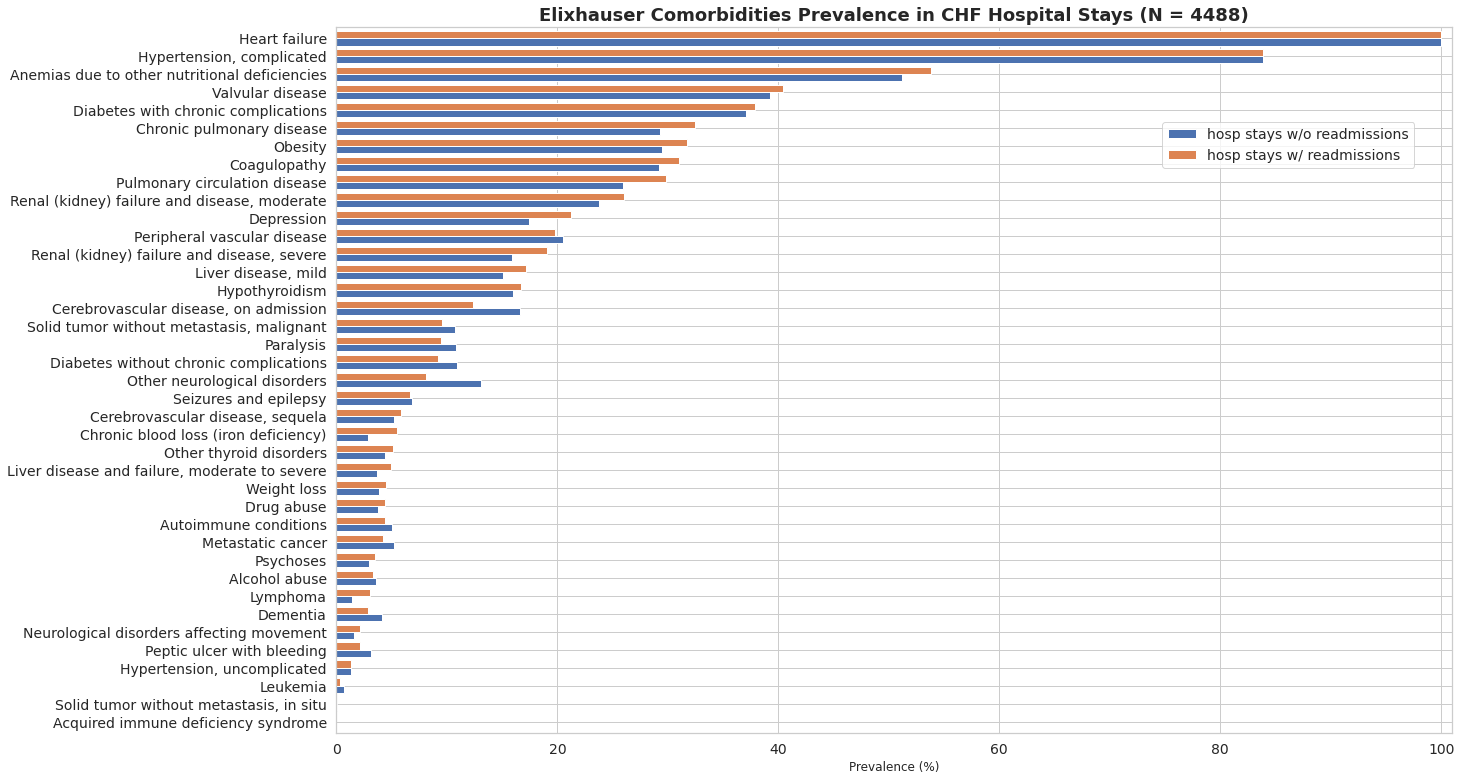

In [34]:
elix_features = elix_features.rename(abbrev, axis = 1)
lab0 = elix_features[elix_features.labels == 0]
lab1 = elix_features[elix_features.labels == 1]

df = pd.DataFrame()
df['hosp stays w/o readmissions'] = lab0.iloc[:, 7:].sum()/len(lab0)*100
df['hosp stays w/ readmissions'] = lab1.iloc[:, 7:].sum()/len(lab1)*100
df = df.sort_values('hosp stays w/ readmissions')

sns.set_theme(style = 'whitegrid')
ax = df.plot.barh(figsize=(20, 13),  width = 0.8)
plt.title('Elixhauser Comorbidities Prevalence in CHF Hospital Stays (N = {})'.format(len(elix_features)), fontsize = 18, fontweight = 'bold')
plt.xlabel('Prevalence (%)')
plt.xlim([0, 101])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = [0.74, 0.8], fontsize = 14)
plt.show()

#### Appendix
### 1. Elixhauser 
The below are functions that generate elixhauser and charlson comorbidities from ICD-10 codes via Regex.\
*per discussion w/ Dr. F (01/19/23): This uses an outdated version of elixhauser.

In [ ]:
# def elix_comor(df_orig):
#     '''
#     This function adds 31 categories(columns) on a given dataframe that marks comorbidities according to the Elixhauser Comorbidity Index.
#     '''
#     df = df_orig.copy()  
#     df = df.assign( 
#         ECI_CHF = df.icd10_code.str.contains(r'I09.9|I1[13].0|I13.2|I25.5|I42.0|I43|I50|P29.0|I42.[5-9]'),                        # Congestive Heart Failure
#         ECI_CA = df.icd10_code.str.contains(r'I44.[1-3]|I45.[69]|I4[7-9]|R00.[018]|T82.1|Z[49]5.0'),                              # Cardiac Arrhythmias
#         ECI_VALVE = df.icd10_code.str.contains(r'A52.0|I0[5-8]|I09.[18]|I3[4-9]|Q23.[0-3]|Z95.[2-4]'),                            # Valvular Disease
#         ECI_PULMCIRC = df.icd10_code.str.contains(r'I2[67]|I28.[089]'),                                                           # Pulmonary Circulation Disorders
#         ECI_PERIVASC = df.icd10_code.str.contains(r'I7[01]|I73.[189]|I77.1|I79.[02]|K55.[189]|Z95.[89]'),                         # Peripheral Vascular Disorders
#         ECI_HTN = df.icd10_code.str.contains(r'I10'),                                                                             # Hypertension, uncomplicated
#         ECI_HTNCX = df.icd10_code.str.contains(r'I1[1235]'),                                                                      # Hypertension, complicated
#         ECI_PARA = df.icd10_code.str.contains(r'G04.1|G11.4|G80.[12]|G81|G82|G83.[0-4]|G83.9'),                                   # Paralysis
#         ECI_NEURO = df.icd10_code.str.contains(r'G1[0-3]|G2[0-2]|G25.[45]|G31.[289]|G32|G3[5-7]|G4[01]|G93.[14]|R47.0|R56'),      # Other Neurological Disorders
#         ECI_CHRNLUNG = df.icd10_code.str.contains(r'I27.[89]|J4[0-7]|J6[0-7]|J68.4|J70.[13]'),                                    # Chronic Pulmonary Disease
#         ECI_DM = df.icd10_code.str.contains(r'E1[0-4].[019]'),                                                                    # Diabetes, uncomplicated
#         ECI_DMCX = df.icd10_code.str.contains(r'E10.[2-8]|E11.[2-8]|E12.[2-8]|E13.[2-8]|E14.[2-8]'),                              # Diabetes, complicated
#         ECI_HYPOTHY = df.icd10_code.str.contains(r'E0[0-3]|E89.0'),                                                               # Hypothyroidism
#         ECI_RENLFAIL = df.icd10_code.str.contains(r'I12.0|I13.1|N1[89]|N25.0|Z49.[0-2]|Z94.0|Z99.2'),                             # Renal Failure
#         ECI_LIVER = df.icd10_code.str.contains(r'B18|I85|I86.4|I98.2|K70|K71.[17]|K71.[3-5]|K7[2-4]|K76.0|K76.[2-9]|Z94.4'),      # Liver Disease
#         ECI_ULCER = df.icd10_code.str.contains(r'K25.[79]|K26.[79]|K27.[79]|K28.[79]'),                                           # Peptic Ulcer Disease, excluding bleeding
#         ECI_AIDS = df.icd10_code.str.contains(r'B2[0-2]|B24'),                                                                    # AIDS/HIV
#         ECI_LYMPH = df.icd10_code.str.contains(r'C8[1-5]|C88|C96|C90.[02]'),                                                      # Lymphoma
#         ECI_METS = df.icd10_code.str.contains(r'C7[7-9]|C80'),                                                                    # Metastatic Cancer
#         ECI_TUMOR = df.icd10_code.str.contains(r'C[0-1]|C2[0-6]|C3[0-4]|C3[7-9]|C4[01]|C43|C4[5-9]|C5[0-8]|C6[0-9]|C7[0-6]|C97'), # Solid tumor without metastasis
#         ECI_ARTH = df.icd10_code.str.contains(r'L94.[013]|M0[568]|M12.[03]|M30|M31.[0-3]|M3[2-5]|M45|M46.[189]'),                 # Rheumatoid arthritis/collagen vascular diseases
#         ECI_COAG = df.icd10_code.str.contains(r'D6[5-8]|D69.[13456]'),                                                            # Coagulopathy
#         ECI_OBESE = df.icd10_code.str.contains(r'E66'),                                                                           # Obesity
#         ECI_WGHTLOSS = df.icd10_code.str.contains(r'E4[0-6]|R63.4|R64'),                                                          # Weight loss
#         ECI_LYTES = df.icd10_code.str.contains(r'E22.2|E8[67]'),                                                                  # Fluid and Electrolyte Disorders
#         ECI_BLDLOSS = df.icd10_code.str.contains(r'D50.0'),                                                                       # Blood Loss Anemia
#         ECI_ANEMDEF = df.icd10_code.str.contains(r'D50.[89]|D5[1-3]'),                                                            # Deficiency Anemia
#         ECI_ALCOHOL = df.icd10_code.str.contains(r'F10|E52|G62.1|I42.6|K29.2|K70.[039]|T51|Z50.2|Z71.4|Z72.1'),                   # Alcohol Abuse
#         ECI_DRUG = df.icd10_code.str.contains(r'F1[1-6]|F1[89]|Z71.5|Z72.2'),                                                     # Drug Abuse
#         ECI_PSYCH = df.icd10_code.str.contains(r'F2[0234589]|F3[01].2|F31.5'),                                                    # Psychoses
#         ECI_DEPRESS = df.icd10_code.str.contains(r'F20.4|F31.[3-5]|F3[23]|F34.1|F41.2|F43.2')                                     # Depression
#     )
#     return df

In [ ]:
#def charl_comor(df_orig):
#    '''
#    This function adds 17 categories(columns) on a given dataframe that marks comorbidities according to the Charlson Comorbidity Index.
#    '''
#    df = df_orig.copy()
#    df = df.assign(
#        CCI_MYOCARD = df.icd10_code.str.contains(r'I2[12]|I25.2'),                                                             # Myocardial infarction
#        CCI_CHF = df.icd10_code.str.contains(r'I09.9|I1[13].0|I13.2|I25.5|I42.0|I42.[5-9]|I43|I50|P29.0'),                     # Congestive heart failure
#        CCI_PERIVASC = df.icd10_code.str.contains(r'I7[01]|I73.[189]|I77.1|I79.[02]|K55.[189]|Z95.[89]'),                      # Peripheral vascular disease
#        CCI_CEREB = df.icd10_code.str.contains(r'G4[56]|H34.0|I6[0-9]'),                                                       # Cerebrovascular disease
#        CCI_DEMEN = df.icd10_code.str.contains(r'F0[0-3]|F05.1|G30|G31.1'),                                                    # Dementia
#        CCI_CHRNLUNG = df.icd10_code.str.contains(r'I27.[89]|J4[0-7]|J6[0-7]|J68.4|J70.[13]'),                                 # Chronic pulmonary disease
#        CCI_RHEU = df.icd10_code.str.contains(r'M0[56]|M31.5|M3[2-4]|M35.[13]|M36.0'),                                         # Rheumatic disease
#        CCI_ULCER = df.icd10_code.str.contains(r'K2[5-8]'),                                                                    # Peptic ulcer disease
#        CCI_LIVER = df.icd10_code.str.contains(r'B18|K70.[0-39]|K71.[3457]|K73|K74|K76.[02-4]|K76.[89]|Z94.4'),                # Mild liver disease
#        CCI_DM = df.icd10_code.str.contains(r'E1[0-4].[01689]'),                                                               # Diabetes without chronic complication
#        CCI_DMCX = df.icd10_code.str.contains(r'E1[0-4].[2-57]'),                                                              # Diabetes with chronic complication
#        CCI_HP = df.icd10_code.str.contains(r'G04.1|G11.4|G80.[12]|G8[12]|G83.[0-49]'),                                        # Hemiplegia or paraplegia
#        CCI_RENLFAIL = df.icd10_code.str.contains(r'I12.0|I13.1|N0[35].[2-7]|N1[89]|N25.0|Z49.[0-2]|Z94.0|Z99.2'),             # Renal disease
#        CCI_MAL = df.icd10_code.str.contains(r'C[01][0-9]|C2[0-6]|C3[0-47-9]|C4[0135-8]|C6[0-9]|C7[0-6]|C8[1-58]|C9[0-7]'),    # Any malignancy,including lymphoma and leukemia, except skin malignant neoplasm
#        CCI_SEVLIVER = df.icd10_code.str.contains(r'I85.[09]|I86.4|I98.2|K70.4|K7[12].1|K72.9|K76.[5-7]'),                     # Moderate or severe liver disease
#        CCI_TUMOR = df.icd10_code.str.contains(r'C7[7-9]|C80'),                                                                # Metastatic solid tumor
#        CCI_AIDS = df.icd10_code.str.contains(r'B2[0-24]')                                                                     # AIDS/HIV
#        )
#    return df

### 2. Calculate Elixhauser Comorbidity Scores
Using the van Walraven algorithm (range -19 [less likely for in-hospital death] to 89 [more likely for in-hospital death]) to calculate scores from the Elixhauser Comorbidity Index.\
*per discussion w/ Dr. F (01/19/23): scoring system is devloped from elixhauser w/ ICD-9 codes and should be deleted since it may lose predictive value.

In [ ]:
# keys = df_elix.columns[2:]
# values = [7,5,-1,4,2,0,0,7,6,3,0,0,0,5,11,0,0,9,12,4,0,3,-4,6,5,-2,-2,0,-7,0,-3]
# score_dict = dict(zip(keys, values))
# print(score_dict)

# elix_score = df_elix.iloc[:, 2:].mul(score_dict).sum(axis = 1)
# df_elix['Score'] = elix_score
# df_elix.head()